In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import spacy
from torchtext.legacy.data import Field, TabularDataset, BucketIterator
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
!python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 56.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.2.0
    Uninstalling typing_extensions-4.2.0:
      Successfully uninstalled typing_extensions-4.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.3 requires absl-py~=0.10, but you have absl-py 1.0.0 which is incompatible.
tensorflow 2.6.3 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.3 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.3 requires wrapt~=1.12.1, but you have w

### Starter code from aladdinpersson's Machine Learning Collection
* [Transformer Code](https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/more_advanced/seq2seq_transformer/seq2seq_transformer.py)

* [Creating Dataset](https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/more_advanced/torchtext/torchtext_tutorial1.py)

## Tokenizer

In [3]:
spacy_eng = spacy.load("en_core_web_sm")
def tokenize_eng(text):
    return [tok.text for tok in spacy_eng.tokenizer(text)]

## Split Dataset into Train and Test splits

In [4]:
tweets_df = pd.read_csv('../input/twitter-tweets-sentiment-dataset/Tweets.csv')
tweets_df['sentiment'] = tweets_df['sentiment'].astype('category')
idx_to_cat = dict(enumerate(tweets_df['sentiment'].cat.categories))
cat_columns = tweets_df.select_dtypes(['category']).columns
tweets_df[cat_columns] = tweets_df[cat_columns].apply(lambda x: x.cat.codes)

test_split = int(len(tweets_df)*0.70)
train_df = tweets_df[:test_split]
test_df = tweets_df[test_split:]

train_df.to_csv('tweets_train.csv')
test_df.to_csv('tweets_test.csv')

# Train and Test iterators

In [5]:
tweet = Field(sequential=True, use_vocab=True, tokenize=tokenize_eng, lower=True, init_token="<sos>", eos_token="<eos>")
sentiment = Field(sequential=False, use_vocab=False)

fields = {"selected_text": ("tweet", tweet), "sentiment": ("sentiment", sentiment)}

train_data, test_data = TabularDataset.splits(
    path="./",
    train="tweets_train.csv", test="tweets_test.csv",
    format="csv", fields=fields
)

tweet.build_vocab(train_data, max_size=10000, min_freq=2)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 96

train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data), batch_size=batch_size, device=device, sort=False
)

## Transformer Model

In [8]:
class Transformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        src_vocab_size,
        num_heads,
        num_encoder_layers,
        forward_dim,
        dropout,
        max_len,
        num_classes,
        device,
    ):
        super(Transformer, self).__init__()
        
        self.embedding = nn.Embedding(src_vocab_size, embedding_size).to(device)
        self.pos_embedding = nn.Embedding(max_len+1, embedding_size).to(device)
        # we add +1 to account for the class embedding to be concatenated at the start of the sequence
        
        cls_token_weights = torch.randn(1, 1, embedding_size).to(device) # initialize class token weights
        self.cls_token = nn.Parameter(cls_token_weights).to(device)
        
        self.device = device
        self.transformer_enc_layer = nn.TransformerEncoderLayer(embedding_size, num_heads, forward_dim, dropout).to(device)
        self.transformer_enc = nn.TransformerEncoder(self.transformer_enc_layer, num_encoder_layers).to(device)

        self.fc_clf = nn.Sequential(
            nn.Linear(embedding_size, embedding_size),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(embedding_size, embedding_size),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(embedding_size, num_classes),
        ).to(device)
        
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        seq_length, N = src.shape
        
        src_positions = torch.arange(0, seq_length+1).unsqueeze(1).expand(seq_length+1, N).to(self.device)
        
        embed = self.embedding(src).to(self.device)
        cls_token_batch = self.cls_token.repeat(1, N, 1).to(self.device)
        embed = torch.cat((cls_token_batch, embed), 0).to(self.device)
        embed_src = self.dropout(embed + self.pos_embedding(src_positions)).to(self.device)
        
        out = self.transformer_enc(embed_src).to(self.device)
        cls_tokens = out[0, :, :].to(self.device)
        out = self.fc_clf(cls_tokens).to(self.device)
        return out

## Function for computing F1

In [9]:
def f1_score_from_prob(class_probs, labels, from_gpu=True):
    if from_gpu:
        class_probs = class_probs.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
    preds = class_probs.argmax(1)
    return f1_score(labels, preds, average='macro')

## Train step function (single epoch)

In [10]:
def train_step(model, loss, optim, scheduler, train_iterator, device):
    cumm_epoch_loss = 0
    cumm_epoch_f1 = 0
        
    for data_pair in tqdm(train_iterator):
        tweet = data_pair.tweet.to(device)
        target = data_pair.sentiment.to(device)
            
        optim.zero_grad()
            
        pred = model(tweet).to(device)
        batch_loss = loss(pred, target).to(device)
        batch_loss.backward()
        optim.step()
            
            
        cumm_epoch_loss += batch_loss
        cumm_epoch_f1 += f1_score_from_prob(pred, target, from_gpu=True)
    
    if scheduler is not None:
        scheduler.step()
        
    epoch_loss = cumm_epoch_loss/len(train_iterator)
    epoch_f1 = cumm_epoch_f1/len(train_iterator)
    
    return epoch_loss, epoch_f1

## Validation Function

In [11]:
def validate(model, loss, test_iterator, device):
    model.eval()
    with torch.no_grad():
        cumm_loss = 0
        cumm_f1 = 0
        
        for data_pair in test_iterator:
            tweet = data_pair.tweet.to(device)
            target = data_pair.sentiment.to(device)
            
            pred = model(tweet).to(device)
            batch_loss = loss(pred, target).to(device)
            
            cumm_loss += batch_loss
            cumm_f1 += f1_score_from_prob(pred, target, from_gpu=True)
    
    test_loss = cumm_loss/len(test_iterator)
    test_f1 = cumm_f1/len(test_iterator)
    return test_loss, test_f1

## Define Model

In [54]:
model = Transformer(embedding_size=256,
        src_vocab_size=10000,
        num_heads=8,
        num_encoder_layers=6,
        forward_dim=256,
        dropout=0.5,
        max_len=110,
        num_classes=3,
        device=device)

## Training

In [55]:
verbose = False

optim = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=8e-4) # weight_decay value was picked after trial and error
scheduler = None
loss = nn.CrossEntropyLoss()
    
train_losses = []
train_f1s = []
    
test_losses = []
test_f1s = []

epochs = 60 # after trial and error, 60 epochs seemed to be the sweet spot between bias and variance
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    model.train()
    epoch_loss, epoch_f1 = train_step(model, loss, optim, scheduler, train_iterator, device)
    test_loss, test_f1 = validate(model, loss, test_iterator, device)
        
    train_losses.append(epoch_loss.cpu().detach().numpy())
    train_f1s.append(epoch_f1)
    test_losses.append(test_loss.cpu().detach().numpy())
    test_f1s.append(test_f1)
        
    if verbose:
        print(f'Train Loss: {epoch_loss}')
        print(f'Train F1 Score: {epoch_f1}')
        print(f'Test Loss: {test_loss}')
        print(f'Test F1 Score: {test_f1}')


Epoch 1/60


100%|██████████| 201/201 [00:06<00:00, 29.16it/s]


Epoch 2/60


100%|██████████| 201/201 [00:06<00:00, 29.53it/s]


Epoch 3/60


100%|██████████| 201/201 [00:06<00:00, 29.07it/s]


Epoch 4/60


100%|██████████| 201/201 [00:06<00:00, 29.55it/s]


Epoch 5/60


100%|██████████| 201/201 [00:07<00:00, 28.51it/s]


Epoch 6/60


100%|██████████| 201/201 [00:06<00:00, 30.01it/s]


Epoch 7/60


100%|██████████| 201/201 [00:06<00:00, 29.93it/s]


Epoch 8/60


100%|██████████| 201/201 [00:07<00:00, 28.53it/s]


Epoch 9/60


100%|██████████| 201/201 [00:06<00:00, 29.21it/s]


Epoch 10/60


100%|██████████| 201/201 [00:06<00:00, 30.03it/s]


Epoch 11/60


100%|██████████| 201/201 [00:06<00:00, 29.44it/s]


Epoch 12/60


100%|██████████| 201/201 [00:07<00:00, 28.16it/s]


Epoch 13/60


100%|██████████| 201/201 [00:06<00:00, 30.09it/s]


Epoch 14/60


100%|██████████| 201/201 [00:06<00:00, 29.61it/s]


Epoch 15/60


100%|██████████| 201/201 [00:06<00:00, 29.30it/s]


Epoch 16/60


100%|██████████| 201/201 [00:06<00:00, 28.74it/s]


Epoch 17/60


100%|██████████| 201/201 [00:06<00:00, 30.01it/s]


Epoch 18/60


100%|██████████| 201/201 [00:06<00:00, 28.95it/s]


Epoch 19/60


100%|██████████| 201/201 [00:06<00:00, 29.48it/s]


Epoch 20/60


100%|██████████| 201/201 [00:06<00:00, 29.31it/s]


Epoch 21/60


100%|██████████| 201/201 [00:07<00:00, 28.61it/s]


Epoch 22/60


100%|██████████| 201/201 [00:06<00:00, 29.59it/s]


Epoch 23/60


100%|██████████| 201/201 [00:06<00:00, 30.04it/s]


Epoch 24/60


100%|██████████| 201/201 [00:06<00:00, 30.16it/s]


Epoch 25/60


100%|██████████| 201/201 [00:06<00:00, 28.90it/s]


Epoch 26/60


100%|██████████| 201/201 [00:06<00:00, 30.05it/s]


Epoch 27/60


100%|██████████| 201/201 [00:06<00:00, 29.61it/s]


Epoch 28/60


100%|██████████| 201/201 [00:06<00:00, 29.44it/s]


Epoch 29/60


100%|██████████| 201/201 [00:07<00:00, 28.38it/s]


Epoch 30/60


100%|██████████| 201/201 [00:06<00:00, 29.75it/s]


Epoch 31/60


100%|██████████| 201/201 [00:06<00:00, 29.24it/s]


Epoch 32/60


100%|██████████| 201/201 [00:06<00:00, 29.48it/s]


Epoch 33/60


100%|██████████| 201/201 [00:06<00:00, 28.81it/s]


Epoch 34/60


100%|██████████| 201/201 [00:06<00:00, 29.26it/s]


Epoch 35/60


100%|██████████| 201/201 [00:06<00:00, 29.61it/s]


Epoch 36/60


100%|██████████| 201/201 [00:06<00:00, 30.06it/s]


Epoch 37/60


100%|██████████| 201/201 [00:06<00:00, 30.16it/s]


Epoch 38/60


100%|██████████| 201/201 [00:07<00:00, 27.53it/s]


Epoch 39/60


100%|██████████| 201/201 [00:06<00:00, 29.46it/s]


Epoch 40/60


100%|██████████| 201/201 [00:06<00:00, 29.65it/s]


Epoch 41/60


100%|██████████| 201/201 [00:06<00:00, 29.17it/s]


Epoch 42/60


100%|██████████| 201/201 [00:07<00:00, 28.17it/s]


Epoch 43/60


100%|██████████| 201/201 [00:06<00:00, 29.92it/s]


Epoch 44/60


100%|██████████| 201/201 [00:06<00:00, 29.36it/s]


Epoch 45/60


100%|██████████| 201/201 [00:06<00:00, 29.65it/s]


Epoch 46/60


100%|██████████| 201/201 [00:07<00:00, 27.98it/s]


Epoch 47/60


100%|██████████| 201/201 [00:06<00:00, 29.75it/s]


Epoch 48/60


100%|██████████| 201/201 [00:06<00:00, 29.16it/s]


Epoch 49/60


100%|██████████| 201/201 [00:06<00:00, 29.25it/s]


Epoch 50/60


100%|██████████| 201/201 [00:06<00:00, 28.85it/s]


Epoch 51/60


100%|██████████| 201/201 [00:06<00:00, 29.39it/s]


Epoch 52/60


100%|██████████| 201/201 [00:06<00:00, 29.27it/s]


Epoch 53/60


100%|██████████| 201/201 [00:06<00:00, 29.99it/s]


Epoch 54/60


100%|██████████| 201/201 [00:06<00:00, 28.73it/s]


Epoch 55/60


100%|██████████| 201/201 [00:06<00:00, 29.42it/s]


Epoch 56/60


100%|██████████| 201/201 [00:06<00:00, 29.49it/s]


Epoch 57/60


100%|██████████| 201/201 [00:06<00:00, 30.13it/s]


Epoch 58/60


100%|██████████| 201/201 [00:07<00:00, 28.64it/s]


Epoch 59/60


100%|██████████| 201/201 [00:06<00:00, 29.24it/s]


Epoch 60/60


100%|██████████| 201/201 [00:06<00:00, 29.60it/s]


## Train and Test Loss + Metrics

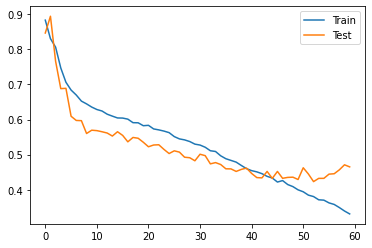

In [57]:
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.legend()

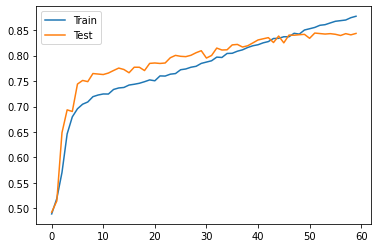

In [58]:
plt.plot(train_f1s, label='Train')
plt.plot(test_f1s, label='Test')
plt.legend()

In [59]:
def get_preds_targets(data_iterator, model, device):
    preds = torch.Tensor().to(device)
    targets = torch.Tensor().to(device)
    
    with torch.no_grad():
        for data_pair in data_iterator:
            tweet = data_pair.tweet.to(device)
            target = data_pair.sentiment.to(device)
            pred = model(tweet).to(device)
            
            preds = torch.cat((preds, pred), 0)
            targets = torch.cat((targets, target), 0)
    
    preds = preds.argmax(1)
    preds = preds.cpu().detach().numpy()
    targets = targets.cpu().detach().numpy()
    
    return preds, targets
    
train_preds, train_targets = get_preds_targets(train_iterator, model, device)
test_preds, test_targets = get_preds_targets(test_iterator, model, device)

In [60]:
test_loss, test_f1 = validate(model, loss, test_iterator, device)
train_loss, train_f1 = validate(model, loss, train_iterator, device)
train_acc, test_acc = accuracy_score(train_targets, train_preds), accuracy_score(test_targets, test_preds)

print(f"Train Loss: {train_loss}")
print(f"Train F1 Score: {train_f1}")
print(f"Train Acc: {train_acc}")
print(f"Test Loss: {test_loss}")
print(f"Test F1 Score: {test_f1}")
print(f"Test Acc: {test_acc}")

Train Loss: 0.2641199827194214
Train F1 Score: 0.9054052882385033
Train Acc: 0.907413183614057
Test Loss: 0.46506357192993164
Test F1 Score: 0.8435457382837459
Test Acc: 0.8454821103699212


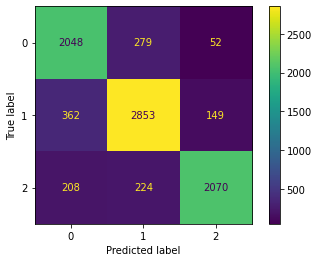

In [64]:
cm = confusion_matrix(test_targets, test_preds)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot()